In [22]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os

# 创建输出目录
if not os.path.exists('restaurant_plots'):
    os.makedirs('restaurant_plots')

# 加载数据
df = pd.read_csv('tripadvisor_shanghai_cleaned.csv')

# 重新设置列名
df.columns = ['餐厅评分', '评论数量', '价格标识', '餐厅类型', '餐厅地址', '餐厅名', '网页链接']

# 定义价格档次映射
price_mapping = {
    '¥': '经济型',
    '¥¥ - ¥¥¥': '中端型',
    '¥¥¥¥': '高端型'
}

# 将价格标识转换为价格档次
df['价格档次'] = df['价格标识'].map(price_mapping)

# 提取主要的餐厅类型（只取逗号前的部分）
df['主要餐厅类型'] = df['餐厅类型'].apply(lambda x: x.split(',')[0])

# 从餐厅地址中提取区信息
def extract_district(address):
    districts = ['黄浦区', '浦东新区', '徐汇区', '长宁区', '静安区', '普陀区',
                 '虹口区', '杨浦区', '闵行区', '宝山区', '嘉定区', '金山区',
                 '松江区', '青浦区', '奉贤区', '崇明区']
    for district in districts:
        if district in address:
            return district
    return None

df['区'] = df['餐厅地址'].apply(extract_district)

  

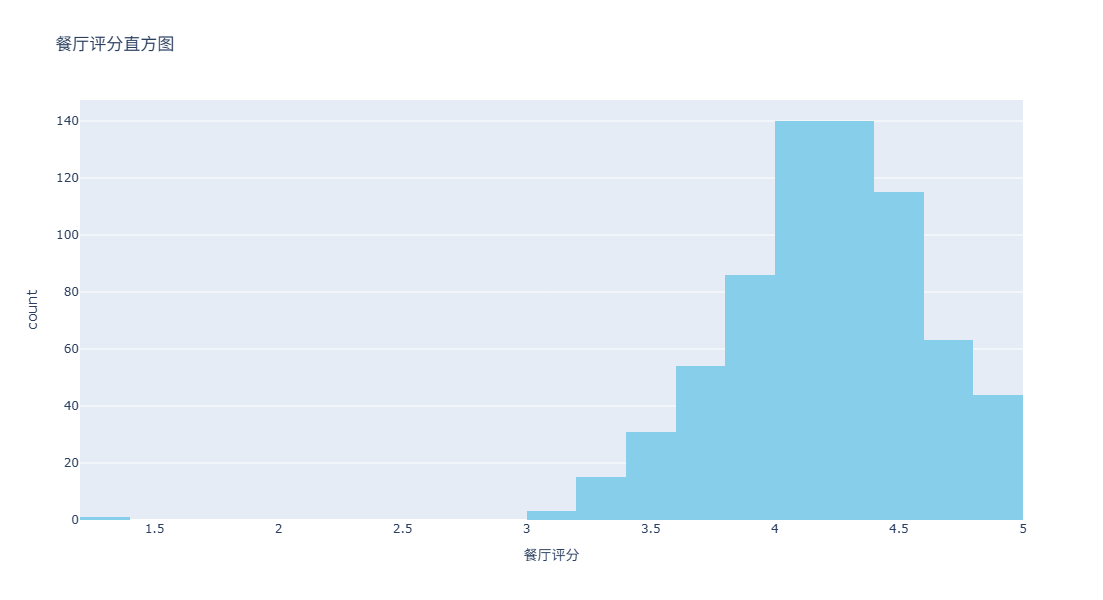

In [23]:
# 1. 餐厅评分的直方图
fig1 = px.histogram(df, x='餐厅评分', nbins=20,
                    color_discrete_sequence=['skyblue'],
                    title='餐厅评分直方图')
fig1.update_layout(width=800, height=600)
fig1.write_html('restaurant_plots/1_rating_histogram.html')
fig1.show()


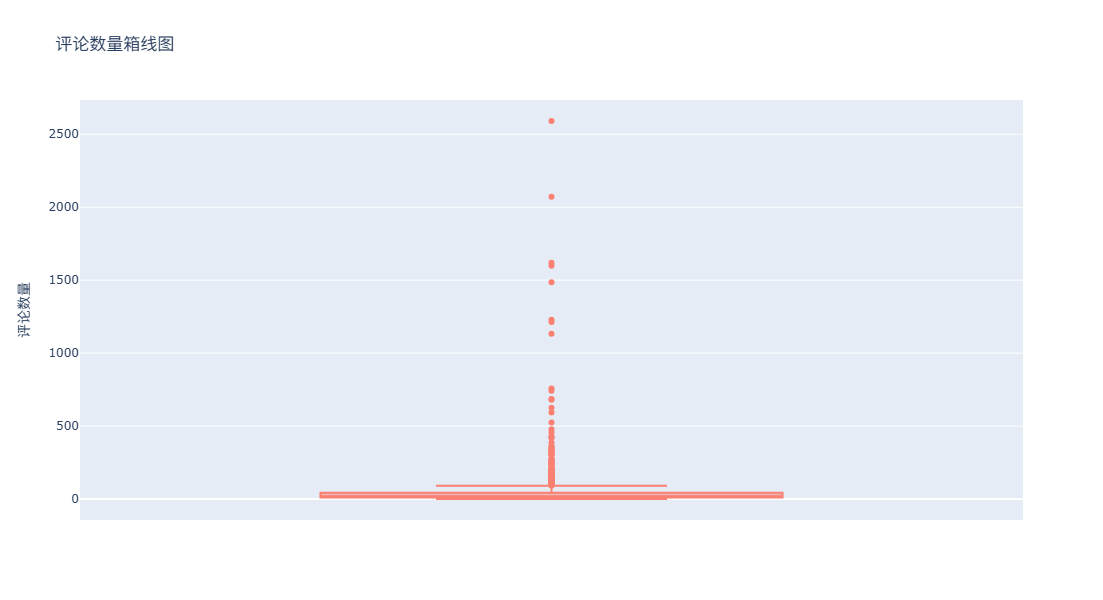

In [24]:
# 2. 评论数量的箱线图
fig2 = px.box(df, y='评论数量',
              color_discrete_sequence=['salmon'],
              title='评论数量箱线图')
fig2.update_layout(width=800, height=600)
fig2.write_html('restaurant_plots/2_review_boxplot.html')
fig2.show()
 

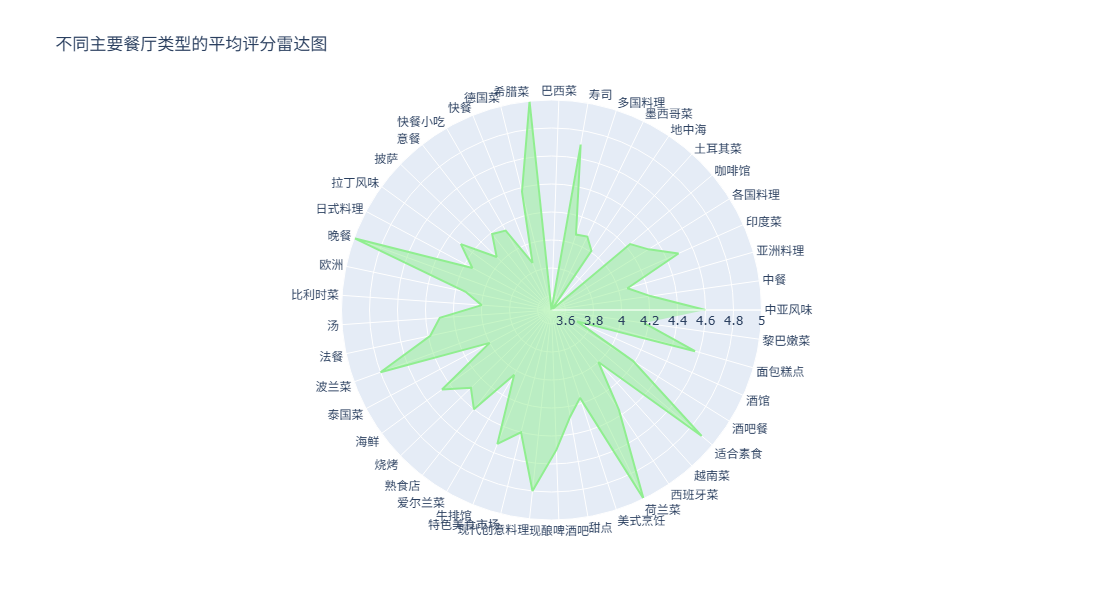

In [25]:
# 3. 不同主要餐厅类型的平均评分雷达图
avg_rating_by_main_type = df.groupby('主要餐厅类型')['餐厅评分'].mean().reset_index()
fig3 = go.Figure(data=go.Scatterpolar(
    r=avg_rating_by_main_type['餐厅评分'],
    theta=avg_rating_by_main_type['主要餐厅类型'],
    fill='toself',
    marker_color='lightgreen'
))
fig3.update_layout(
    polar=dict(
        radialaxis=dict(range=[3.5, 5])
    ),
    title='不同主要餐厅类型的平均评分雷达图',
    width=800,
    height=600
)
fig3.write_html('restaurant_plots/3_type_radar_chart.html')
fig3.show()


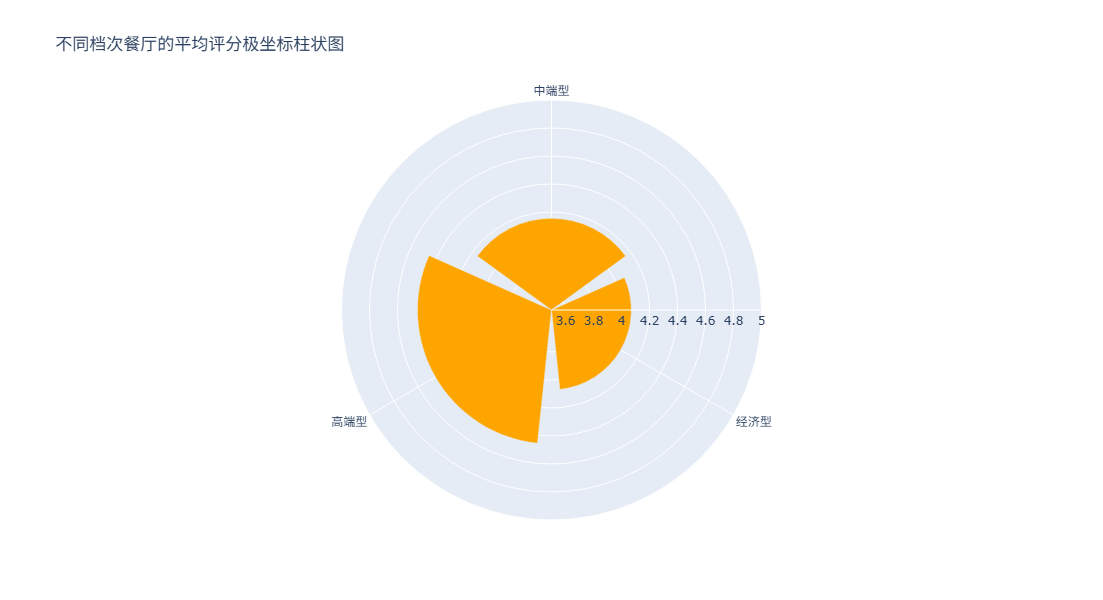

In [26]:
# 4. 不同档次餐厅的平均评分极坐标柱状图
avg_rating_by_price_level = df.groupby('价格档次')['餐厅评分'].mean().reset_index()
fig4 = px.bar_polar(avg_rating_by_price_level, r='餐厅评分', theta='价格档次',
                   color_discrete_sequence=['orange'],
                   title='不同档次餐厅的平均评分极坐标柱状图')
fig4.update_polars(radialaxis=dict(range=[3.5, 5]))
fig4.update_layout(width=800, height=600)
fig4.write_html('restaurant_plots/4_price_polar_bar.html')
fig4.show()
   

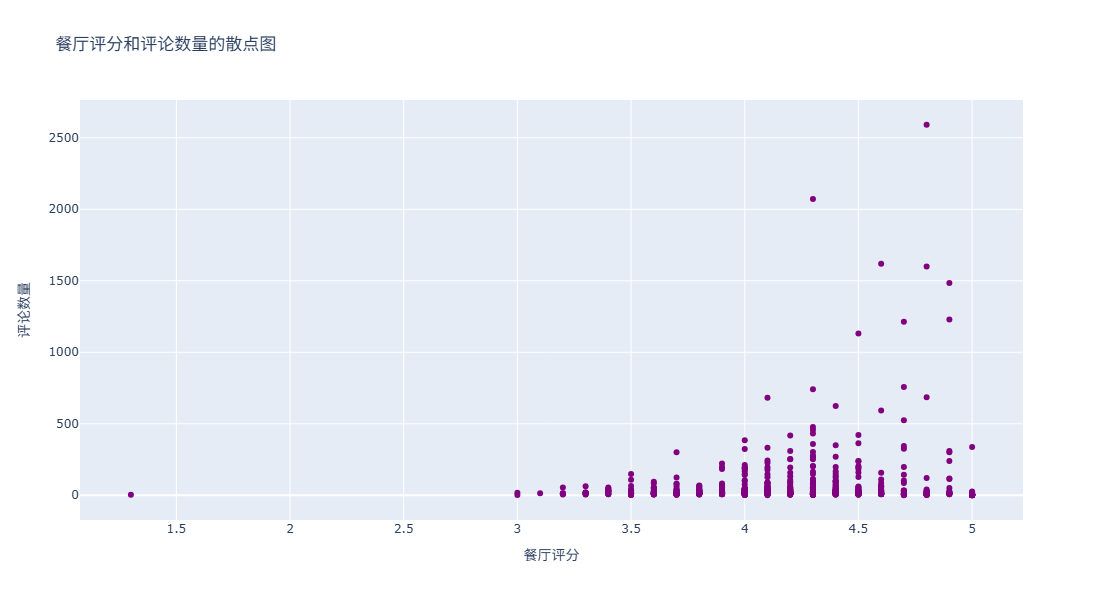

In [27]:
# 5. 餐厅评分和评论数量的散点图
fig5 = px.scatter(df, x='餐厅评分', y='评论数量',
                 color_discrete_sequence=['purple'],
                 title='餐厅评分和评论数量的散点图')
fig5.update_layout(width=800, height=600)
fig5.write_html('restaurant_plots/5_rating_review_scatter.html')
fig5.show()

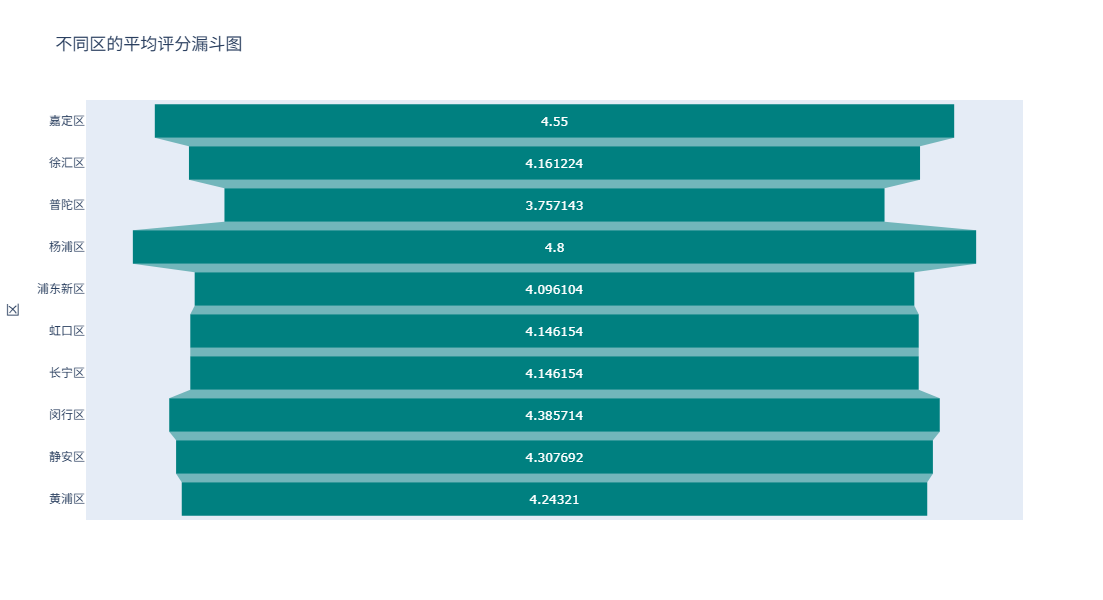

In [28]:
# 6. 不同区的平均评分漏斗图
avg_rating_by_district = df.groupby('区')['餐厅评分'].mean().reset_index()
fig6 = px.funnel(avg_rating_by_district, x='餐厅评分', y='区',
                color_discrete_sequence=['teal'],
                title='不同区的平均评分漏斗图')
fig6.update_layout(width=800, height=600)
fig6.write_html('restaurant_plots/6_district_funnel.html')
fig6.show()

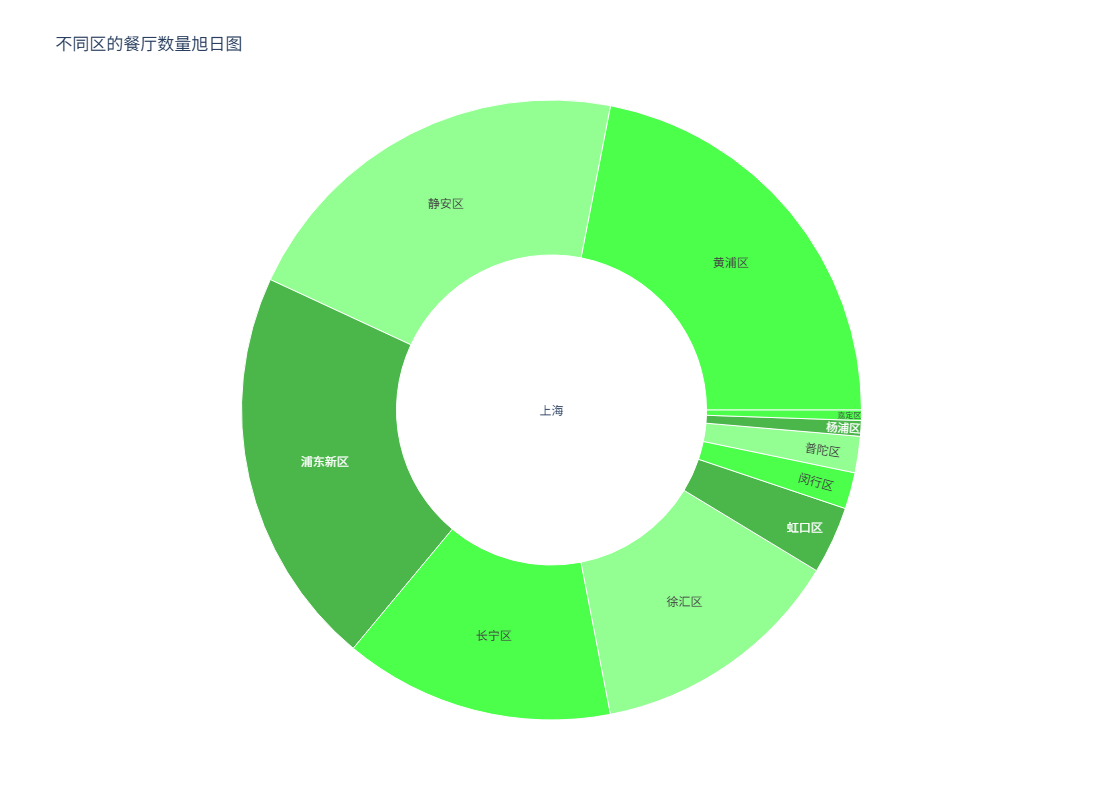

In [29]:
# 7. 不同区的餐厅数量旭日图
district_counts = df['区'].value_counts().reset_index(name='餐厅数量')
district_counts['parent'] = '上海'
fig7 = px.sunburst(district_counts, names='区', parents='parent', values='餐厅数量',
                  color_discrete_sequence=['lime'],
                  title='不同区的餐厅数量旭日图')
fig7.update_layout(width=800, height=800)
fig7.write_html('restaurant_plots/7_district_sunburst.html')
fig7.show()

C:\Users\11354\AppData\Local\Temp\ipykernel_3136\2034597693.py:26: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



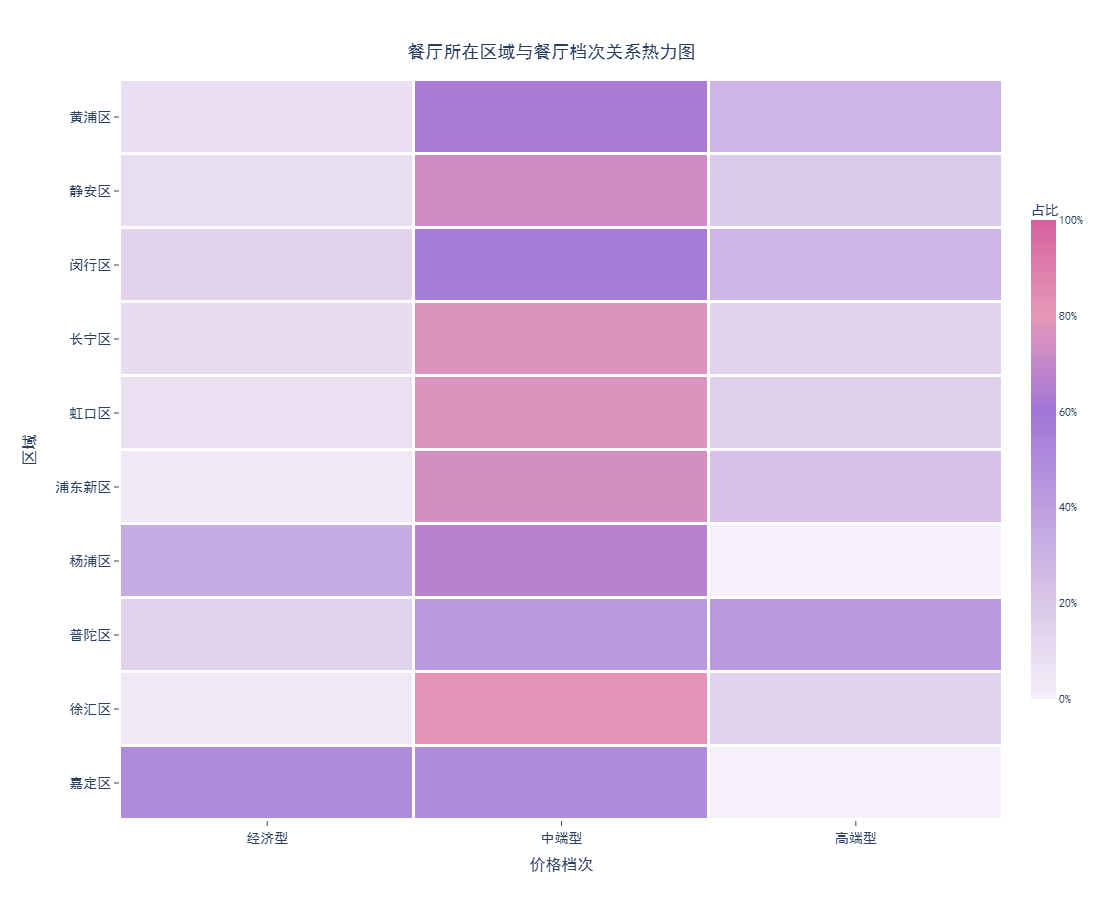

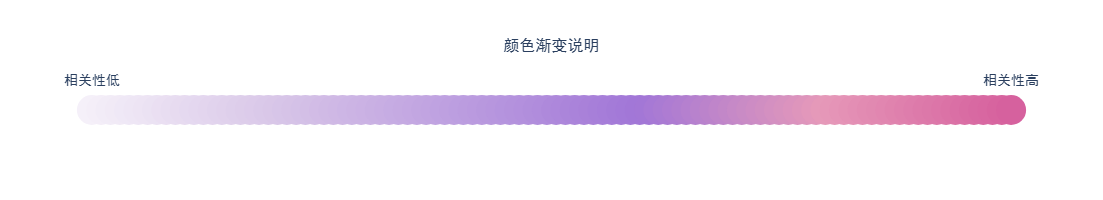

In [35]:
# 8. 餐厅所在区域与餐厅档次关系热力图（优化配色）
cross_tab = pd.crosstab(df['区'], df['价格档次'])
cross_tab = cross_tab.div(cross_tab.sum(axis=1), axis=0)  # 转换为比例

# 定义高级紫粉色渐变（从浅紫到深粉）
custom_colorscale = [
    [0, '#f5f0f9'],   # 最小值：极浅紫
    [0.2, '#d9c7e8'], # 低比例：浅紫
    [0.4, '#bd9fe0'], # 中低比例：中紫
    [0.6, '#a176d7'], # 中高比例：深紫
    [0.8, '#e699b9'], # 高比例：浅粉
    [1, '#d6619e']    # 最大值：深粉
]

# 定义餐厅类型顺序（按价格从低到高）
price_order = ['经济型', '中端型', '高端型']

fig8 = go.Figure(data=go.Heatmap(
    x=price_order,  # 按价格排序
    y=cross_tab.index,
    z=cross_tab[price_order].values,  # 按价格排序
    colorscale=custom_colorscale,
    zmin=0,
    zmax=1,
    hoverinfo='text',
    text=cross_tab[price_order].applymap(lambda x: f'{x:.1%}'),  # 悬停显示百分比
    showscale=True,
    colorbar=dict(
        title='占比',
        tickformat='.0%',
        thickness=25,  # 增加色标厚度
        len=0.7,       # 色标长度（占图表高度比例）
        x=1.02,        # 色标位置（微调）
        title_font=dict(size=14, family='SimHei'),  # 中文字体支持
        tickfont=dict(size=12, family='SimHei')
    ),
    xgap=3,  # 增加列间距
    ygap=3   # 增加行间距
))

fig8.update_layout(
    title=dict(
        text='餐厅所在区域与餐厅档次关系热力图',
        font=dict(size=18, family='SimHei'),  # 中文字体支持
        x=0.5,  # 标题居中
        y=0.95  # 标题位置微调
    ),
    xaxis=dict(
        title=dict(
            text='价格档次',
            font=dict(size=16, family='SimHei')
        ),
        tickfont=dict(size=14, family='SimHei'),
        showgrid=False,
        ticks='outside',  # 刻度线在外
        ticklen=5,        # 刻度线长度
        tickwidth=1       # 刻度线宽度
    ),
    yaxis=dict(
        title=dict(
            text='区域',
            font=dict(size=16, family='SimHei')
        ),
        tickfont=dict(size=14, family='SimHei'),
        showgrid=False,
        ticks='outside',
        ticklen=5,
        tickwidth=1
    ),
    plot_bgcolor='rgba(0,0,0,0)',  # 完全透明背景
    paper_bgcolor='rgba(0,0,0,0)',  # 完全透明背景
    margin=dict(t=80, b=80, l=120, r=60),  # 调整边距
    width=1200,
    height=900
)

# 添加交互效果
fig8.update_traces(
    hovertemplate='<b>%{y}</b><br>%{x}: %{text}<extra></extra>',  # 优化悬停模板
    selector=dict(type='heatmap')
)

fig8.write_html('restaurant_plots/8_district_price_heatmap.html')
fig8.show()

# 新增：创建颜色图例
import numpy as np

# 创建渐变颜色带数据
x = np.linspace(0, 1, 100)
y = np.ones(100)

# 创建颜色图例
fig_legend = go.Figure()

# 添加渐变颜色带
fig_legend.add_trace(go.Scatter(
    x=x,
    y=y,
    mode='markers',
    marker=dict(
        size=30,
        color=x,
        colorscale=custom_colorscale,
        showscale=False
    ),
    hoverinfo='none'
))

# 添加高低标签
fig_legend.add_annotation(
    x=0,
    y=1,
    text='相关性低',
    showarrow=False,
    yshift=30,
    font=dict(size=14, family='SimHei')
)

fig_legend.add_annotation(
    x=1,
    y=1,
    text='相关性高',
    showarrow=False,
    yshift=30,
    font=dict(size=14, family='SimHei')
)

# 添加标题
fig_legend.update_layout(
    title=dict(
        text='颜色渐变说明',
        font=dict(size=16, family='SimHei'),
        x=0.5,
        y=0.8
    ),
    xaxis=dict(
        showticklabels=False,
        showgrid=False,
        zeroline=False
    ),
    yaxis=dict(
        showticklabels=False,
        showgrid=False,
        zeroline=False,
        range=[0.9, 1.1]
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    width=600,
    height=200,
    margin=dict(t=50, b=30, l=20, r=20)
)

# 保存和显示图例
fig_legend.write_html('restaurant_plots/color_legend.html')
fig_legend.show()      